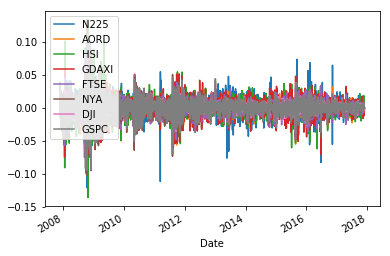

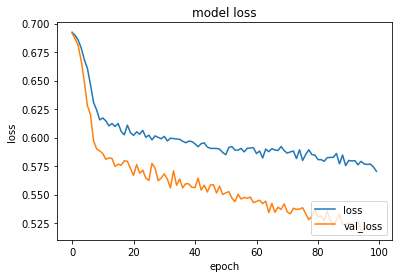

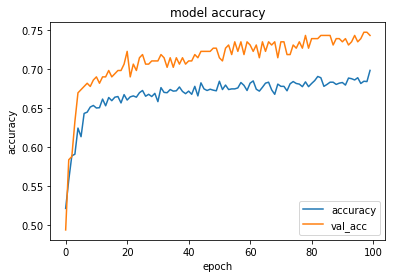

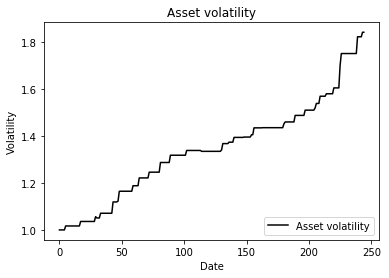

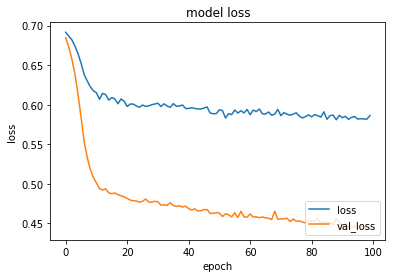

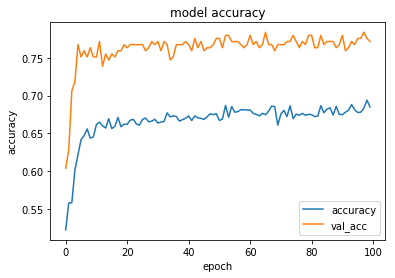

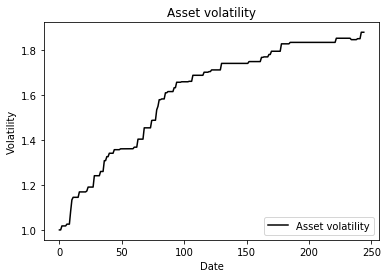

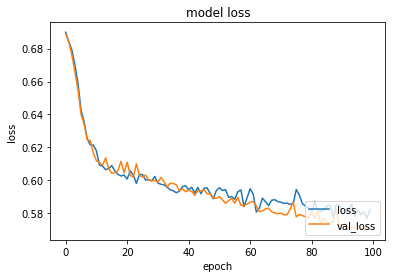

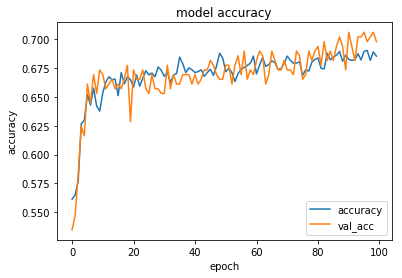

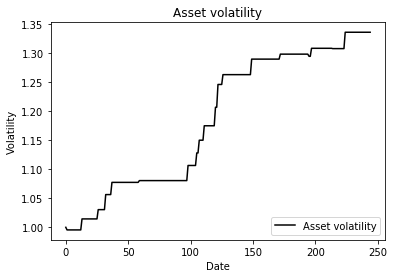

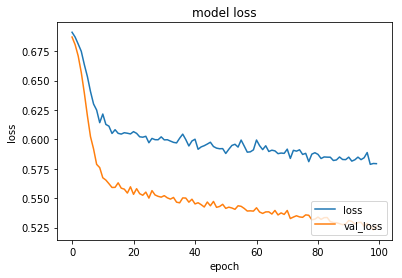

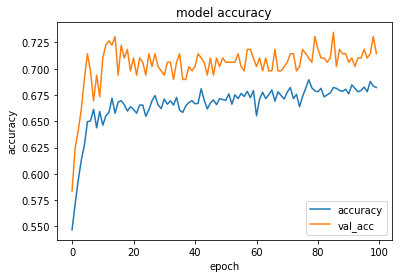

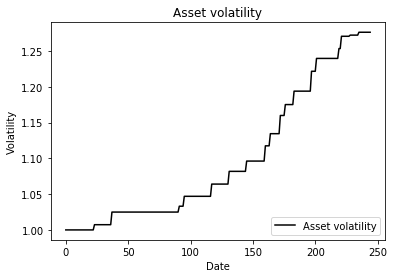

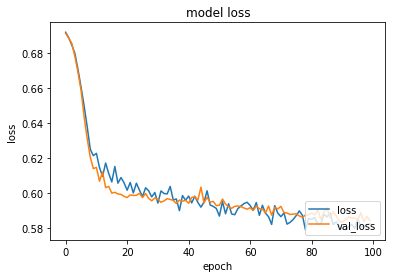

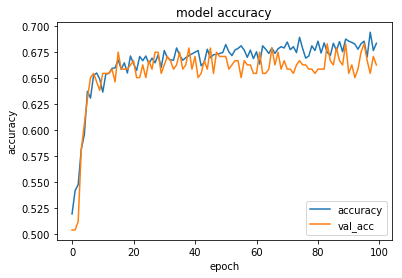

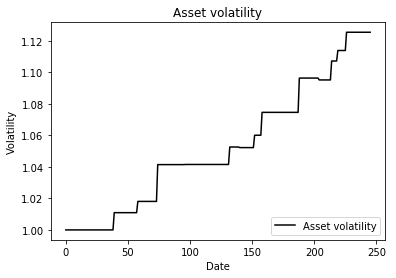

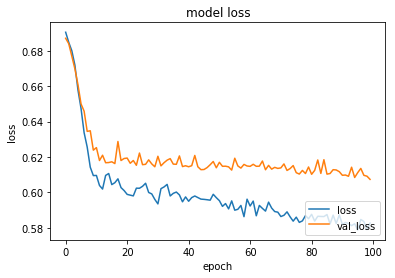

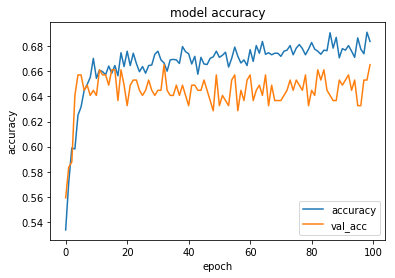

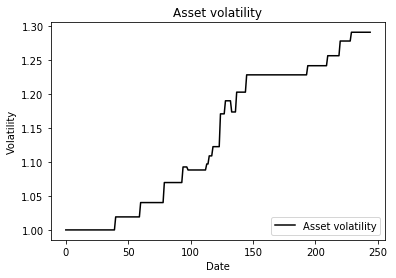

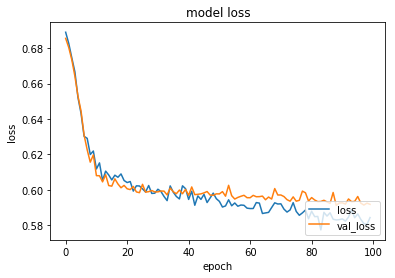

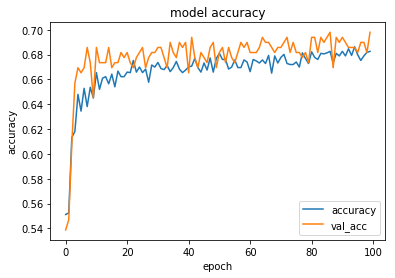

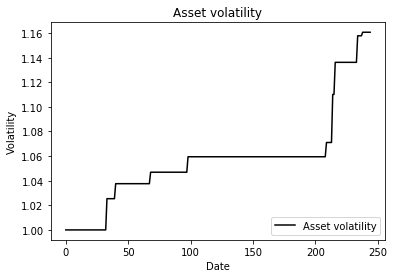

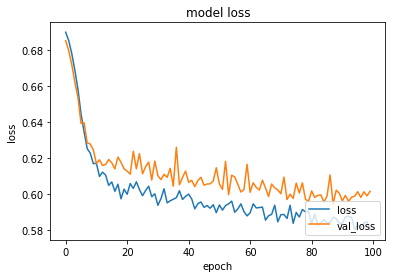

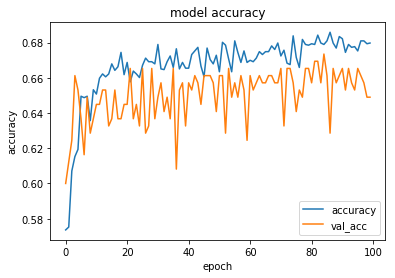

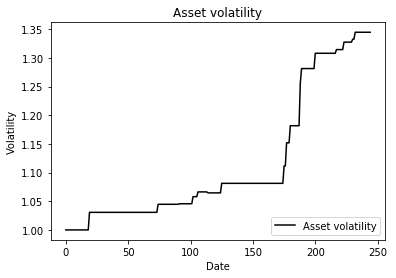

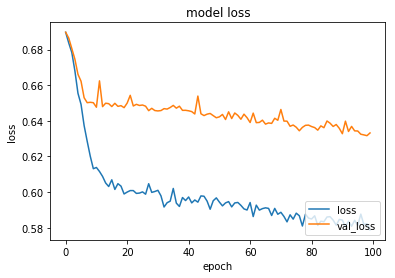

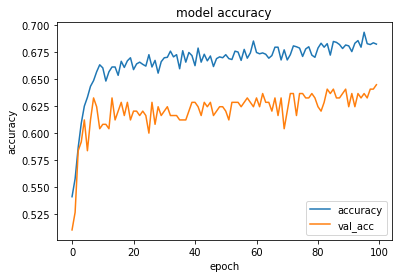

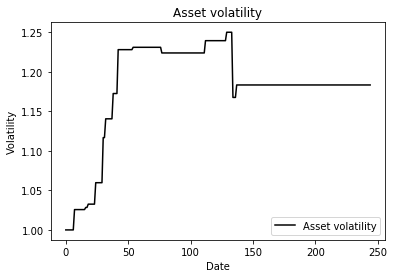

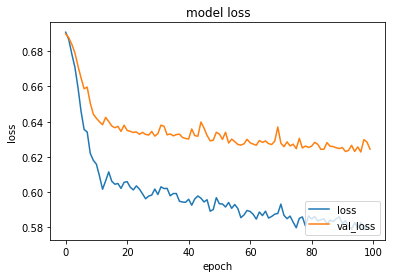

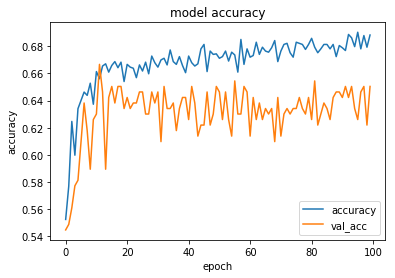

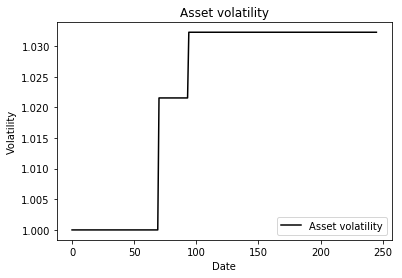

elapsed_time : 103.96571254730225 [sec]


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# ダウンロードしてきたやつ
INDEIES = ["N225",
           "AORD",
           "HSI",
           "GDAXI",
           "FTSE",
           "NYA",
           "DJI",
           "GSPC",
          ]
ANSWER = "N225"

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("../data/input5/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = df["Close"]
        if index is ANSWER:
            closing["LH"] = (df["Close"].shift()-df["Low"])*(df["High"]-df["Close"].shift())
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    LH = np.array(closing["LH"])
    del closing["LH"]
    for index in INDEIES:
        #closing[index] = closing[index] / max(closing[index])
        closing[index] = np.log(closing[index] / closing[index].shift())
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing, LH

def getTraningData():
    closing, LH = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["negative", "positive"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    for i in range(4, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    # 予測する元のデータ , 予測するべきデータ
    return features, answers, LH

def nn_model(in_n, out_n):
    model = Sequential()
    model.add(Dense(units=64, input_dim=in_n))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=out_n))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

if __name__ == "__main__":
    start = time.time()
    features, answers, LH = getTraningData()
    popo = 10
    for test in range(0,popo):
        model = nn_model(len(features.columns), len(answers.columns))
        low_number = int(len(features)*(test*(1/popo)))
        high_number = int(len(features)*(test*(1/popo)+(1/popo)))
        test_features = np.array(features[low_number:high_number])
        test_answers = np.array(answers[low_number:high_number])
        test_LH = np.array(LH[low_number:high_number])
        for i in range(low_number, high_number):
            train_features=np.array(features.drop([i]))
            train_answers=np.array(answers.drop([i]))
        history = model.fit(train_features, train_answers, epochs=100, batch_size=128, \
                            validation_data=(test_features,test_answers), verbose=0)
        answer = model.predict(test_features)
        # 損失の履歴をプロット
        plt.plot(history.history['loss'],label="loss",)
        plt.plot(history.history['val_loss'],label="val_loss")
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(loc='lower right')
        plt.show()
        # 精度の履歴をプロット
        plt.plot(history.history['acc'],label="accuracy")
        plt.plot(history.history['val_acc'],label="val_acc")
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(loc="lower right")
        plt.show()
        value = [1]
        for i in range(1, len(test_answers)):
            temp_value = 0
            if answer[i-1][0] > 0.5 and test_LH[i] > 0: temp_value = -test_features[i][0]
            if answer[i-1][1] > 0.5 and test_LH[i] > 0: temp_value = +test_features[i][0]
            value.append(temp_value+value[-1])
        plt.plot(value, 'k-', label='Asset volatility')
        plt.title('Asset volatility')
        plt.xlabel('Date')
        plt.ylabel('Volatility')
        plt.legend(loc='lower right')
        plt.show()
    print("elapsed_time :", time.time()-start, "[sec]")